In [67]:
import os, glob  #glob is a library used to search for files matching a pattern.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
#model libarary
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random




#1/ Data clone from repo



In [32]:
# data uploding
!git clone https://github.com/jaldwehi/LiPo_Battery_DataScience_project-2.git


fatal: destination path 'LiPo_Battery_DataScience_project-2' already exists and is not an empty directory.


In [33]:

repo_path = "/content/LiPo_Battery_DataScience_project-2"
data_path = os.path.join(repo_path, "Data", "raw_stress_discharge")

csv_files = glob.glob(os.path.join(data_path, "*.csv"))

len(csv_files), csv_files[:5] # First 5 file names.


(540,
 ['/content/LiPo_Battery_DataScience_project-2/Data/raw_stress_discharge/2_494_stressdischarge.csv',
  '/content/LiPo_Battery_DataScience_project-2/Data/raw_stress_discharge/2_28_stressdischarge.csv',
  '/content/LiPo_Battery_DataScience_project-2/Data/raw_stress_discharge/2_17_stressdischarge.csv',
  '/content/LiPo_Battery_DataScience_project-2/Data/raw_stress_discharge/2_119_stressdischarge.csv',
  '/content/LiPo_Battery_DataScience_project-2/Data/raw_stress_discharge/2_377_stressdischarge.csv'])

In [34]:

sample_file = csv_files[0] # always inspect one file first to understand the structure
sample_file


'/content/LiPo_Battery_DataScience_project-2/Data/raw_stress_discharge/2_494_stressdischarge.csv'

In [35]:
df = pd.read_csv(sample_file)
df.head()


,Time (s),Current (A),Voltage(V)
0,0.423024,-2.999584,3.773866
1,1.423081,-2.999609,3.730780
2,2.423139,-2.999636,3.710088
3,3.423196,-2.999672,3.694808
4,4.423253,-2.999675,3.682250


# **2/ check column names**
# - Why are we doing this?
Because before merging thousands of rows, we must ensure:

*   all files have same schema
*   no missing columns
*   no weird variations like "Voltage (V)" vs "Voltage(V)"

If they are different → we fix before merging.







In [36]:
cols_list=[]

for i in csv_files[:10]:  # check only first 10 files
   df_temp=pd.read_csv(i)
   cols_list.append(df_temp.columns.tolist())
print(cols_list)

[['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)'], ['Time (s)', 'Current (A)', 'Voltage(V)']]


# **3/ Combine ALL 539 files into ONE dataset**

In [37]:
all_data=[]

for i in csv_files:
  df_temp=pd.read_csv(i)
  df_temp['file_name']=i.split('/')[-1] # add file name for reference
  all_data.append(df_temp)

merged_df=pd.concat(all_data,ignore_index=True) #ignore_index=True → reset row numbering (0,1,2,...N)
merged_df.shape
merged_df.head()

,Time (s),Current (A),Voltage(V),file_name
0,0.423024,-2.999584,3.773866,2_494_stressdischarge.csv
1,1.423081,-2.999609,3.730780,2_494_stressdischarge.csv
2,2.423139,-2.999636,3.710088,2_494_stressdischarge.csv
3,3.423196,-2.999672,3.694808,2_494_stressdischarge.csv
4,4.423253,-2.999675,3.682250,2_494_stressdischarge.csv


# **4/ Cleaning the merged data**

In [38]:
# keep only needed columns
merged_df = merged_df[["Time (s)", "Current (A)", "Voltage(V)", "file_name"]]

# drop rows with missing values
merged_df = merged_df.dropna(subset=["Time (s)", "Current (A)", "Voltage(V)"])

# ensure numeric types
merged_df["Time (s)"]   = pd.to_numeric(merged_df["Time (s)"], errors="coerce")
merged_df["Current (A)"] = pd.to_numeric(merged_df["Current (A)"], errors="coerce")
merged_df["Voltage(V)"]  = pd.to_numeric(merged_df["Voltage(V)"], errors="coerce")

#Dropna again
#Now we remove the rows with the new NaNs

merged_df = merged_df.dropna(subset=["Time (s)", "Current (A)", "Voltage(V)"])

# sort by file + time
merged_df = merged_df.sort_values(["file_name", "Time (s)"]).reset_index(drop=True)

merged_df.head()

,Time (s),Current (A),Voltage(V),file_name
0,0.424024,-2.999613,3.845777,2_0_stressdischarge.csv
1,1.424081,-2.999645,3.819954,2_0_stressdischarge.csv
2,2.424139,-2.999644,3.806625,2_0_stressdischarge.csv
3,3.424196,-2.999647,3.796640,2_0_stressdischarge.csv
4,4.424253,-2.999651,3.788354,2_0_stressdischarge.csv


# **5/ Load capacity file in Colab**

In [39]:


repo_path = "/content/LiPo_Battery_DataScience_project-2"

capacity_path = os.path.join(
    repo_path,
    "Data",
    "Capacity",
    "Capacity_stress (2).csv"
)

capacity_df = pd.read_csv(capacity_path, header=None)  # file has one column, no header
capacity_df.head()


,0
0,0.994927
1,0.995762
2,0.994096
3,0.993263
4,0.992429


In [40]:
# 1) rename the only column to 'capacity'
capacity_df.columns = ["capacity"]

# 2) create Cycle numbers 0,1,2,..., n-1
capacity_df["Cycle"] = range(len(capacity_df))

# 3) put columns in nice order
capacity_df = capacity_df[["Cycle", "capacity"]]

capacity_df.head()

,Cycle,capacity
0,0,0.994927
1,1,0.995762
2,2,0.994096
3,3,0.993263
4,4,0.992429


# **6/ Compute New Features From Raw Data**

We will extract for each cycle:


*   Avg_V
*   Min_V
*   Max_V
*   Drop_Rate
*   Avg_I
*   Duration



In [41]:
final_features = []

 # read file
for file in csv_files:
  df =pd.read_csv(file)
  df.columns = ["Time", "Current", "Voltage"]

 # extract cycle number from filename
  cycle = int(file.split("/")[-1].split("_")[1])


 # compute features
  avg_v = df["Voltage"].mean()
  min_v = df["Voltage"].min()
  max_v = df["Voltage"].max()
  drop_rate = (max_v - min_v) / (df["Time"].max() - df["Time"].min())
  avg_i = df["Current"].mean()
  duration = df["Time"].max() - df["Time"].min()

# store results
  final_features.append({
        "Cycle": cycle,
        "Avg_V": avg_v,
        "Min_V": min_v,
        "Max_V": max_v,
        "Drop_Rate": drop_rate,
        "Avg_I": avg_i,
        "Duration": duration
    })

# convert to dataframe
features_df = pd.DataFrame(final_features).sort_values("Cycle").reset_index(drop=True)
features_df.head()


,Cycle,Avg_V,Min_V,Max_V,Drop_Rate,Avg_I,Duration
0,0,3.286932,2.747808,3.845777,0.000920,-2.999782,1193.999293
1,1,3.289586,2.743886,3.850977,0.000926,-2.999785,1195.000350
2,2,3.290842,2.749405,3.852211,0.000924,-2.999785,1193.000236
3,3,3.291327,2.749553,3.853476,0.000926,-2.999786,1192.000179
4,4,3.291663,2.749923,3.853858,0.000927,-2.999784,1191.000122


# **7/ Merge capacity_df + features_df**

In [42]:
final_df = features_df.copy()
final_df["capacity"] = capacity_df["capacity"].values


cols = ["Cycle", "capacity", "Avg_V", "Min_V", "Max_V", "Drop_Rate", "Avg_I", "Duration"]

final_df = final_df[cols]

final_df.head()


,Cycle,capacity,Avg_V,Min_V,Max_V,Drop_Rate,Avg_I,Duration
0,0,0.994927,3.286932,2.747808,3.845777,0.000920,-2.999782,1193.999293
1,1,0.995762,3.289586,2.743886,3.850977,0.000926,-2.999785,1195.000350
2,2,0.994096,3.290842,2.749405,3.852211,0.000924,-2.999785,1193.000236
3,3,0.993263,3.291327,2.749553,3.853476,0.000926,-2.999786,1192.000179
4,4,0.992429,3.291663,2.749923,3.853858,0.000927,-2.999784,1191.000122


# ✓  Clean or normalize features
# ✓  Plot curves (Capacity vs Cycle, Avg_V vs Cycle, etc.)
# ✓  Prepare the dataset for ML

# **compute RUL (Remaining Useful Life)**

In [43]:
# 1) Initial capacity
initial_capacity = final_df["capacity"].iloc[0]

# 2) EOL at 80% of initial capacity
#Industry rule: battery reaches EOL when capacity ≤ 80% of initial capacity
eol_threshold = 0.8 * initial_capacity

# 3) Find cycle where capacity first drops below threshold
eol_cycle = final_df[final_df["capacity"] < eol_threshold].iloc[0]["Cycle"]
print(eol_cycle)


50.0


# Compute RUL for each cycle

# **Formula**:

  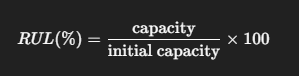

In [44]:
# 4) RUL in percentage
final_df["RUL (%)"] = (final_df["capacity"] / initial_capacity) * 100

# 5) RUL in cycles
final_df["RUL (cycles)"] = eol_cycle - final_df["Cycle"]

final_df.head()

,Cycle,capacity,Avg_V,Min_V,Max_V,Drop_Rate,Avg_I,Duration,RUL (%),RUL (cycles)
0,0,0.994927,3.286932,2.747808,3.845777,0.000920,-2.999782,1193.999293,100.000000,50.0
1,1,0.995762,3.289586,2.743886,3.850977,0.000926,-2.999785,1195.000350,100.083926,49.0
2,2,0.994096,3.290842,2.749405,3.852211,0.000924,-2.999785,1193.000236,99.916404,48.0
3,3,0.993263,3.291327,2.749553,3.853476,0.000926,-2.999786,1192.000179,99.832680,47.0
4,4,0.992429,3.291663,2.749923,3.853858,0.000927,-2.999784,1191.000122,99.748878,46.0


In [45]:
final_df.tail()

,Cycle,capacity,Avg_V,Min_V,Max_V,Drop_Rate,Avg_I,Duration,RUL (%),RUL (cycles)
535,535,0.592456,3.072901,-10.001184,3.758368,0.019325,-2.995570,711.999724,59.547657,-485.0
536,536,0.589124,3.071177,-10.001223,3.758076,0.019434,-2.995550,708.000495,59.212783,-486.0
537,537,0.586624,3.068984,-10.001203,3.756476,0.019514,-2.995529,705.000324,58.961457,-487.0
538,538,0.583290,3.067173,-10.001209,3.755569,0.019625,-2.995506,701.000095,58.626441,-488.0
539,539,0.579958,3.065280,-10.001215,3.755218,0.019737,-2.995483,696.999866,58.291453,-489.0


# **visualization**
**Plot Real RUL (%) per Cycle**

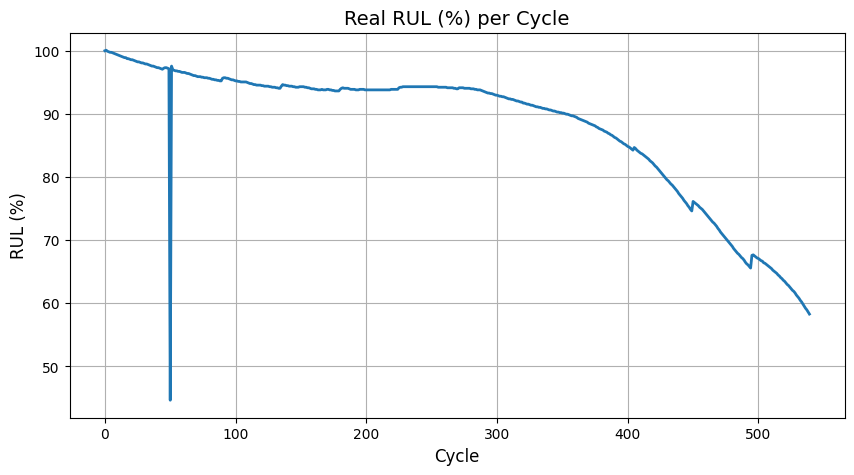

In [46]:
plt.figure(figsize=(10,5))
plt.plot(final_df["Cycle"], final_df["RUL (%)"], linewidth=2)

plt.title("Real RUL (%) per Cycle", fontsize=14)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("RUL (%)", fontsize=12)
plt.grid(True)

plt.show()

**1/ Fix the wrong capacity at Cycle 50t**

In [47]:
# check the three capacities first (optional)
final_df.loc[final_df["Cycle"].isin([49, 50, 51]), ["Cycle", "capacity"]]


,Cycle,capacity
49,49,0.966592
50,50,0.444175
51,51,0.970757


In [48]:
cap_49 = final_df.loc[final_df["Cycle"] == 49, "capacity"].values[0]
cap_51 = final_df.loc[final_df["Cycle"] == 51, "capacity"].values[0]

fixed_value = (cap_49 + cap_51) / 2

final_df.loc[final_df["Cycle"] == 50, "capacity"] = fixed_value

# verify
final_df.loc[final_df["Cycle"].isin([49, 50, 51]), ["Cycle", "capacity"]]

#Now cycle 50 will have a normal value ≈ 0.96 instead of 0.44.

,Cycle,capacity
49,49,0.966592
50,50,0.968674
51,51,0.970757


**2/ Recompute initial_capacity, EOL cycle, and RUL**

In [49]:
# initial capacity (cycle 0)
initial_capacity = final_df["capacity"].iloc[0]

# EOL threshold (80% of initial)
eol_threshold = 0.8 * initial_capacity

# new EOL cycle (first cycle below 80%)
eol_cycle = final_df[final_df["capacity"] < eol_threshold].iloc[0]["Cycle"]
print(eol_cycle)


429.0


**3/ Recalculate RUL columns**

In [50]:
# RUL in percentage
final_df["RUL (%)"] = (final_df["capacity"] / initial_capacity) * 100

# RUL in cycles
final_df["RUL (cycles)"] = eol_cycle - final_df["Cycle"]

final_df.head()


,Cycle,capacity,Avg_V,Min_V,Max_V,Drop_Rate,Avg_I,Duration,RUL (%),RUL (cycles)
0,0,0.994927,3.286932,2.747808,3.845777,0.000920,-2.999782,1193.999293,100.000000,429.0
1,1,0.995762,3.289586,2.743886,3.850977,0.000926,-2.999785,1195.000350,100.083926,428.0
2,2,0.994096,3.290842,2.749405,3.852211,0.000924,-2.999785,1193.000236,99.916404,427.0
3,3,0.993263,3.291327,2.749553,3.853476,0.000926,-2.999786,1192.000179,99.832680,426.0
4,4,0.992429,3.291663,2.749923,3.853858,0.000927,-2.999784,1191.000122,99.748878,425.0


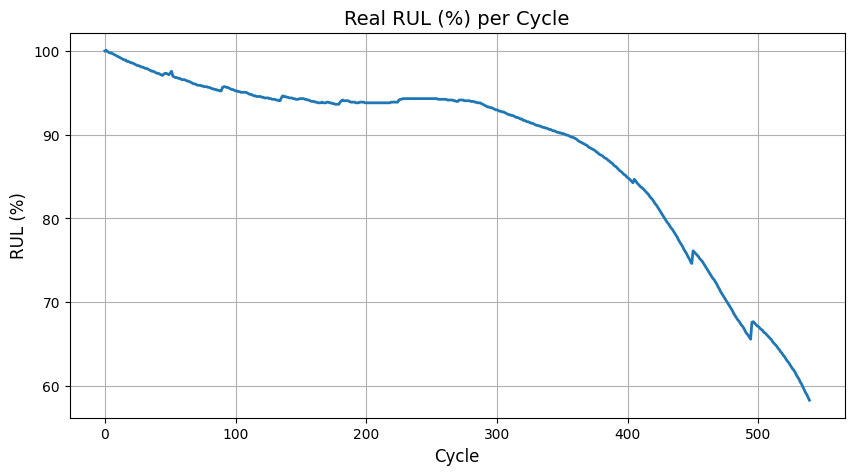

In [51]:

plt.figure(figsize=(10,5))
plt.plot(final_df["Cycle"], final_df["RUL (%)"], linewidth=2)
plt.title("Real RUL (%) per Cycle", fontsize=14)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("RUL (%)", fontsize=12)
plt.grid(True)
plt.show()


# **YAASSSS!!!**

# ***Visualization_section***

# **1) Capacity vs Cycle**
Shows the main degradation curve.

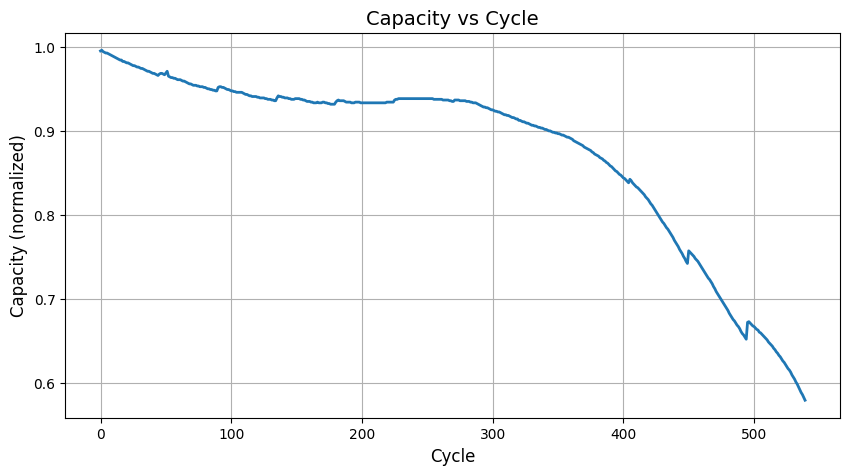

In [52]:

plt.figure(figsize=(10,5))
plt.plot(final_df["Cycle"], final_df["capacity"], linewidth=2)

plt.title("Capacity vs Cycle", fontsize=14)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("Capacity (normalized)", fontsize=12)
plt.grid(True)

plt.show()


# **2) Drop Rate vs Cycle**
Shows how sharply voltage falls — often correlated with aging.

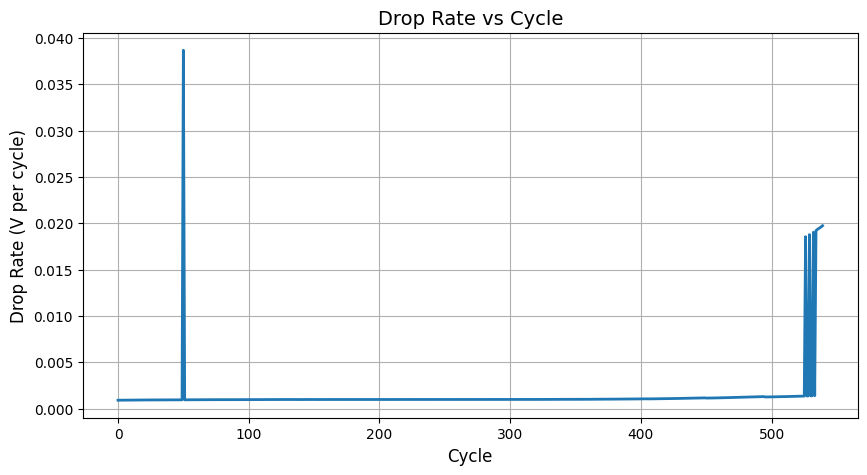

In [53]:

plt.figure(figsize=(10,5))
plt.plot(final_df["Cycle"], final_df["Drop_Rate"], linewidth=2)

plt.title("Drop Rate vs Cycle", fontsize=14)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("Drop Rate (V per cycle)", fontsize=12)
plt.grid(True)

plt.show()


# **3) Voltage Range vs Cycle**
As battery ages → Voltage range shrinks → Predict faster degradation.

In [54]:
final_df = final_df[final_df["Cycle"] < 520] # no need it after drop cycle (threshould)


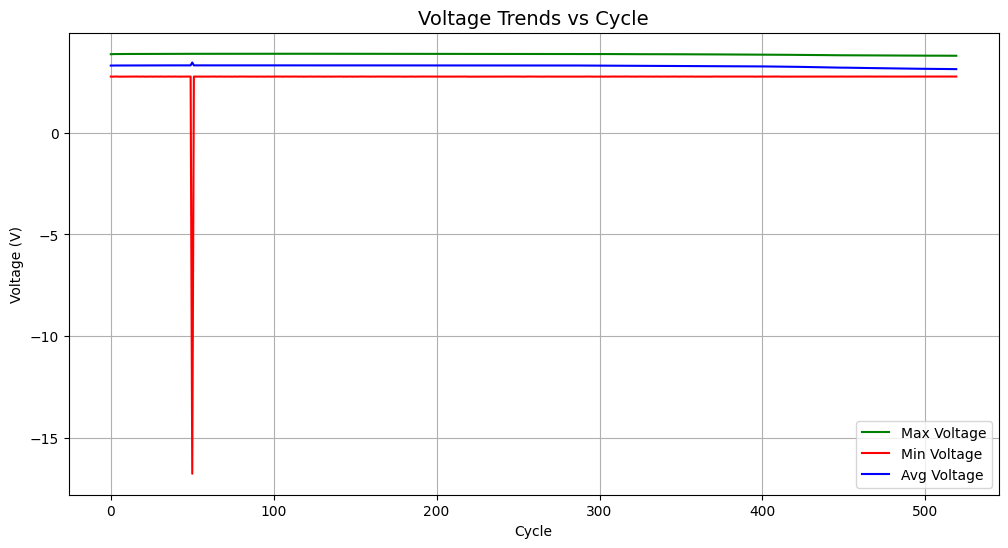

In [55]:
plt.figure(figsize=(12,6))

plt.plot(final_df["Cycle"], final_df["Max_V"], color="green", label="Max Voltage")
plt.plot(final_df["Cycle"], final_df["Min_V"], color="red", label="Min Voltage")
plt.plot(final_df["Cycle"], final_df["Avg_V"], color="blue", label="Avg Voltage")

plt.title("Voltage Trends vs Cycle", fontsize=14)
plt.xlabel("Cycle")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)
plt.show()


#As the battery ages, the maximum voltage it can reach during discharge becomes lower.
#This is a typical aging signature.


# **4) Feature Correlation Heatmap**
full overview of how your features relate to each other


Strong correlations
*   capacity strongly correlates with
      * Avg_V
      * Max_V
      * Drop_Rate (negative correlation)  

 capacity decreases → voltage also decreases → drop rate increases.








In [56]:
# Generate the Correlation Matrix
corr_matrix = final_df.corr()


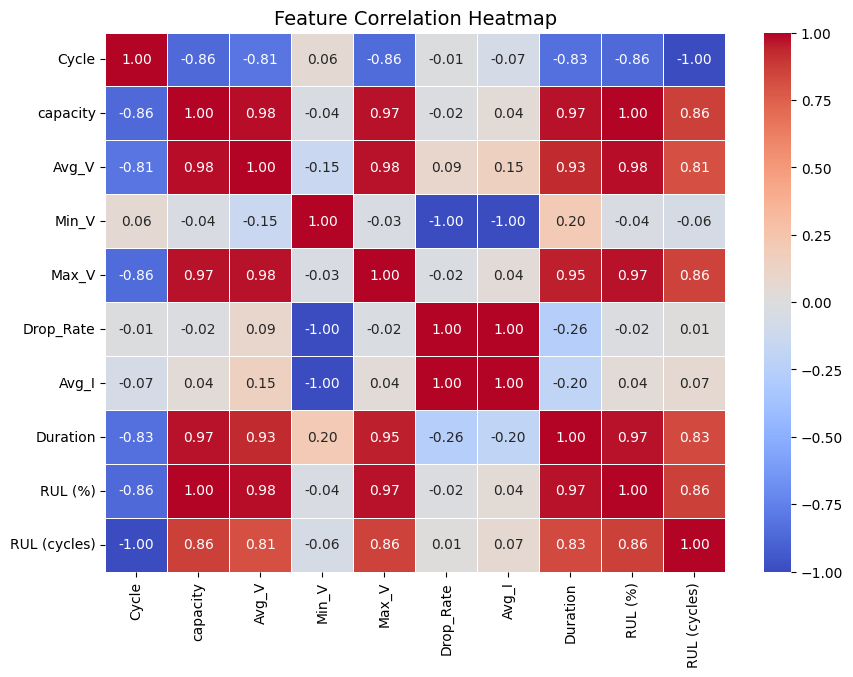

In [57]:
#Plot the Heatmap
plt.figure(figsize=(10,7))

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()


# **5) Capacity Degradation Curve (Smoothed)**
It clearly shows battery health degradation

-Battery capacity starts at ~1.0 and declines steadily as the cycle count increases — exactly what we expect from a LiPo battery under stress discharge.

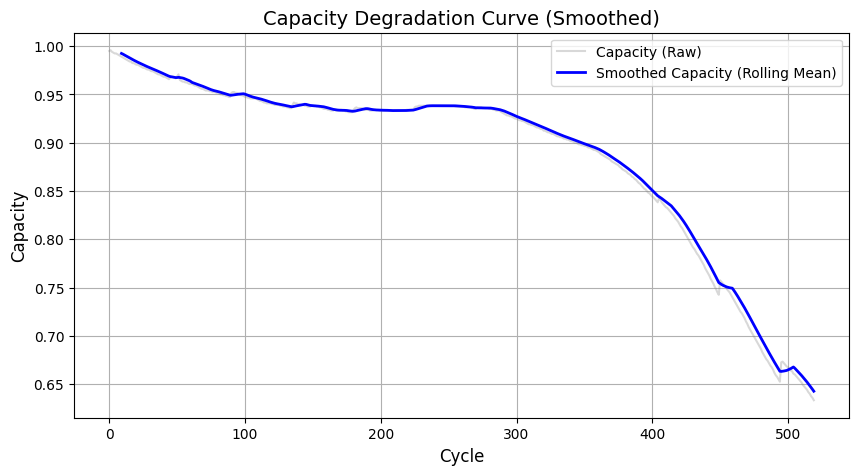

In [58]:
plt.figure(figsize=(10,5))

# Original capacity
plt.plot(final_df["Cycle"], final_df["capacity"], alpha=0.3, label="Capacity (Raw)", color="gray")

# Smoothed capacity
plt.plot(final_df["Cycle"],
         final_df["capacity"].rolling(window=10).mean(),
         linewidth=2,
         label="Smoothed Capacity (Rolling Mean)",
         color="blue")

plt.title("Capacity Degradation Curve (Smoothed)", fontsize=14)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("Capacity", fontsize=12)
plt.grid(True)
plt.legend()

plt.show()


# **Modeling _section**

# 1)  Choose the prediction target
How many cycles are left before EOL?

In [59]:
max_cycle = final_df["Cycle"].max()
final_df["RUL (cycles)"] = max_cycle - final_df["Cycle"]
final_df.head()


,Cycle,capacity,Avg_V,Min_V,Max_V,Drop_Rate,Avg_I,Duration,RUL (%),RUL (cycles)
0,0,0.994927,3.286932,2.747808,3.845777,0.000920,-2.999782,1193.999293,100.000000,519
1,1,0.995762,3.289586,2.743886,3.850977,0.000926,-2.999785,1195.000350,100.083926,518
2,2,0.994096,3.290842,2.749405,3.852211,0.000924,-2.999785,1193.000236,99.916404,517
3,3,0.993263,3.291327,2.749553,3.853476,0.000926,-2.999786,1192.000179,99.832680,516
4,4,0.992429,3.291663,2.749923,3.853858,0.000927,-2.999784,1191.000122,99.748878,515


# 2) Define features and target


In [61]:
#use all engineered features except Cycle and RUL columns

X = final_df[["capacity", "Avg_V", "Min_V", "Max_V",
              "Drop_Rate", "Avg_I", "Duration"]]
y = final_df["RUL (cycles)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Simple baseline model (Random Forest)

In [66]:

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

mae, rmse, r2


(5.5437980769230775, np.float64(25.93538627624576), 0.9732641017726851)

# 4) Plot Predicted vs Actual RUL for 10 random samples

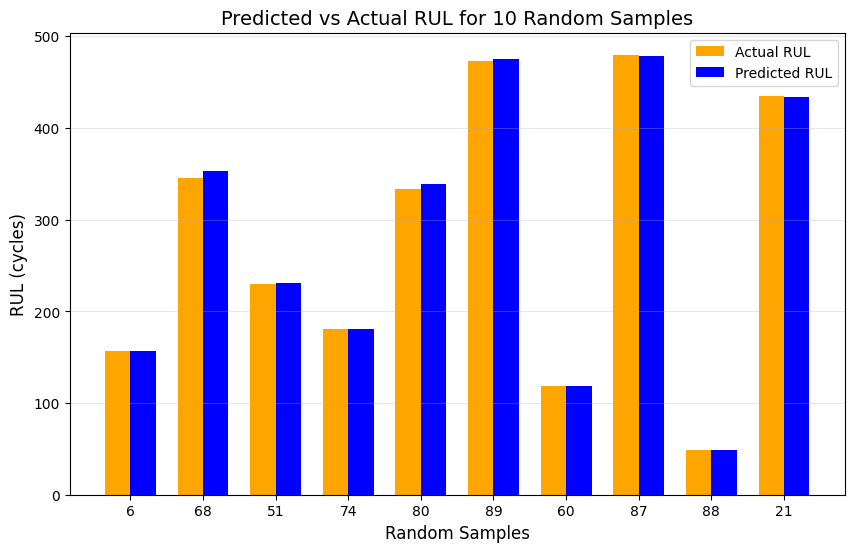

In [70]:
# Convert y_test to numpy array
y_test_array = y_test.values
y_pred_array = y_pred

# Pick 10 random indices
indices = random.sample(range(len(y_test_array)), 10)

actual = y_test_array[indices]
pred = y_pred_array[indices]

x = np.arange(len(indices))  # positions for bars
width = 0.35                 # width of each bar

plt.figure(figsize=(10,6))

# Actual bars
plt.bar(x - width/2, actual, width, label="Actual RUL", color='orange')

# Predicted bars
plt.bar(x + width/2, pred, width, label="Predicted RUL", color='blue')

plt.xlabel("Random Samples", fontsize=12)
plt.ylabel("RUL (cycles)", fontsize=12)
plt.title("Predicted vs Actual RUL for 10 Random Samples", fontsize=14)
plt.xticks(x, indices)  # Show random sample indices
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()